In [1]:
import sys 
sys.path.append('../scripts/')
from mcl import *

In [2]:
class ResetMcl(Mcl):
    def __init__(self, envmap, init_pose, num, motion_noise_stds, \
                 distance_dev_rate=0.14, direction_dev=0.05, alpha_thresholds=[0.0 , 0.01, 0.3]): #αの閾値追加
        super().__init__(envmap, init_pose, num, motion_noise_stds, distance_dev_rate, direction_dev)
        self.alpha_thresholds = alpha_thresholds
        
    def random_reset(self):
         for p in self.particles:
                p.pose = np.array([np.random.uniform(-5.0, 5.0),
                                                 np.random.uniform(-5.0, 5.0),
                                                np.random.uniform(-math.pi, math.pi)]).T
                p.weight = 1/len(self.particles)
        
    def resetting(self):
        self.random_reset()
    
    def observation_update(self, observation):
        for p in self.particles:
            p.observation_update(observation, self.map, self.distance_dev_rate, self.direction_dev) 
        self.set_ml() #リサンプリング前に実行

        alpha = sum([p.weight for p in self.particles]) #αの計算
        obsnum = len(observation)
        
        if obsnum < len(self.alpha_thresholds) and alpha < self.alpha_thresholds[obsnum]:
            self.resetting()
        else:
            self.resampling() 

In [3]:
class ResetMclAgent(MclAgent): 
    def __init__(self, time_interval, nu, omega, particle_pose, envmap, particle_num=100, \
                motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}): #2行目にenvmapを追加
        super().__init__(time_interval, nu, omega, particle_pose, envmap, particle_num, motion_noise_stds)
        self.pf = ResetMcl(envmap, particle_pose, particle_num, motion_noise_stds)

<IPython.core.display.Javascript object>


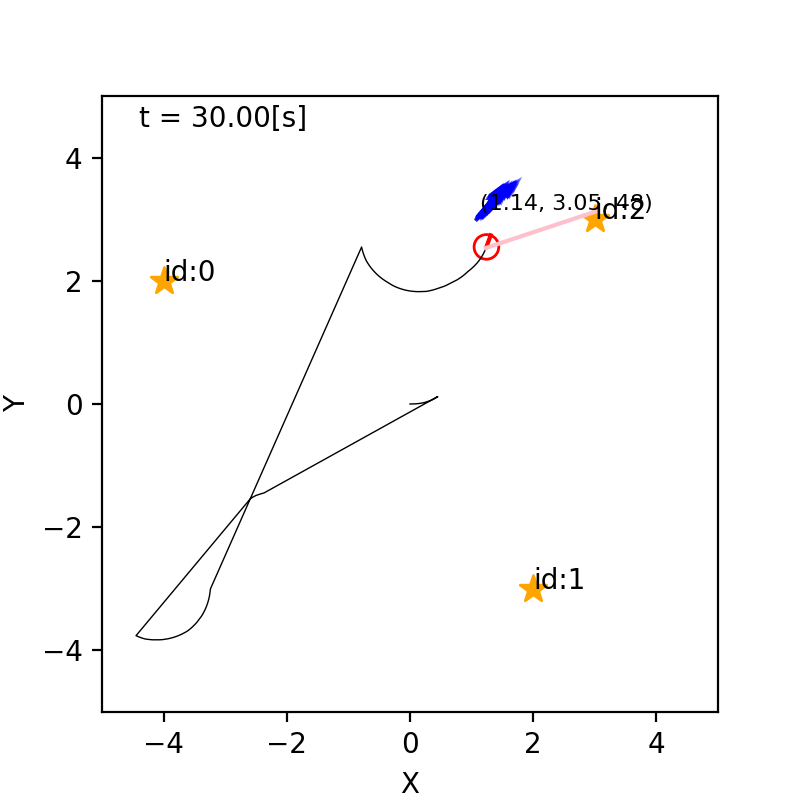

In [4]:
if __name__ == '__main__': 
    time_interval = 0.1
    world = World(30, time_interval, debug=False) 

    ### 地図を生成して3つランドマークを追加 ###
    m = Map()                                  
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)          

    ### ロボットを作る ###
    circling = ResetMclAgent(time_interval, 0.2, 10.0/180*math.pi, np.array([0, 0, 0]).T, m, particle_num=100) #地図を引数で渡す
    r = Robot(np.array([0,0,0]).T, sensor=Camera(m), agent=circling, expected_kidnap_time=10.0, color="red")
    world.append(r)

    world.draw()